In [1]:
#%%
from array import array
from cmath import nan
from pyexpat import model
import statistics
from tkinter.ttk import Separator
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchviz import make_dot
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
from torch.autograd import variable
from itertools import chain
from sklearn import metrics as met
import pickle
from icecream import ic

import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from importlib import reload
# import util
# import model_torch_simple
# from torchmetrics import Accuracy
from tqdm import tqdm
import argparse
from icecream import ic
import numpy as np
from PIL import Image
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [2]:
seed = 42
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

In [3]:
def value_counts_list(lst):
    """
    Computes the frequency count of unique elements in a list and returns a dictionary, sorted by frequency count in
    descending order.

    Args:
    - lst (list): List of elements

    Returns:
    - dict: Dictionary with unique elements as keys and their frequency count as values, sorted by frequency count
    in descending order
    """
    value_counts = {}
    for item in lst:
        if item in value_counts:
            value_counts[item] += 1
        else:
            value_counts[item] = 1
    sorted_value_counts = dict(sorted(value_counts.items(), key=lambda x: x[1], reverse=True))
    return sorted_value_counts

def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

### Loading data

In [4]:
train_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_aa/aa_data_train.csv', delimiter = ',')
train_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_aa/mic_aa_train.csv')
train_target = train_target[['AMI_MIC','EMB_MIC', 'INH_MIC', 'KAN_MIC', 'RIF_MIC', 'RFB_MIC']]
# don't touch test data, split out validation data from training data during training
test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_aa/aa_data_test.csv', delimiter = ',')
test_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_aa/mic_aa_test.csv')
test_target = test_target[['AMI_MIC','EMB_MIC', 'INH_MIC', 'KAN_MIC', 'RIF_MIC', 'RFB_MIC']]

In [6]:
N_samples = train_data.shape[0]
DRUGS = train_target.columns
# LOCI = train_data.columns
assert set(DRUGS) == set(train_target.columns)
N_drugs = len(DRUGS)

# Feature engineering

In [7]:
def one_hot_torch(seq: str, dtype=torch.int8):
    seq_bytes = torch.ByteTensor(list(bytes(seq, "utf-8")))
    acgt_bytes = torch.ByteTensor(list(bytes("ACGT", "utf-8")))
    arr = torch.zeros(4, (len(seq_bytes)), dtype=dtype)
    arr[0, seq_bytes == acgt_bytes[0]] = 1
    arr[1, seq_bytes == acgt_bytes[1]] = 1
    arr[2, seq_bytes == acgt_bytes[2]] = 1
    arr[3, seq_bytes == acgt_bytes[3]] = 1
    return arr

# def one_hot_torch(seq):
#     oh = []
#     for sample in seq:
#         sample = torch.ByteTensor(list(bytes(sample, "utf-8")))
#         acgt_bytes = torch.ByteTensor(list(bytes("ACGT", "utf-8")))
#         arr = torch.zeros((len(sample), 4), dtype=torch.int8)
#         arr[sample == acgt_bytes[0], 0] = 1
#         arr[sample == acgt_bytes[1], 1] = 1
#         arr[sample == acgt_bytes[2], 2] = 1
#         arr[sample == acgt_bytes[3], 3] = 1
#         oh.append(arr)
#     return torch.stack(oh)

def my_padding(seq_tuple):
    list_x_ = list(seq_tuple)
    max_len = len(max(list_x_, key=len))
    for i, x in enumerate(list_x_):
        list_x_[i] = x + "N"*(max_len-len(x))
    return list_x_

#! faster than my_padding try to incorporate
def collate_padded_batch(batch):
    # get max length of seqs in batch
    max_len = max([x[0].shape[1] for x in batch])
    return torch.utils.data.default_collate(
        [(F.pad(x[0], (0, max_len - x[0].shape[1])), x[1]) for x in batch] #how does F.pad work
    )


def get_masked_loss(loss_fn):
    """
    Returns a loss function that ignores NaN values
    """

    def masked_loss(y_true, y_pred):
        y_pred = y_pred.view(-1, 13)  # Ensure y_pred has the same shape as y_true and non_nan_mask
        # ic(y_pred.shape)
        # ic(y_true.shape)
        non_nan_mask = ~y_true.isnan()
        # ic(non_nan_mask)
        y_true_non_nan = y_true[non_nan_mask]
        y_pred_non_nan = y_pred[non_nan_mask]

        return loss_fn(y_pred_non_nan, y_true_non_nan)

    return masked_loss

masked_MSE = get_masked_loss(torch.nn.MSELoss())

# Dateset

In [8]:
# Julian's code - implement this, might be faster
class Dataset(torch.utils.data.Dataset): #? what's the difference between using inheritance and not?
    def __init__(
        self,
        seq_df,
        res_df,
        # target_loci=LOCI,
        target_drugs=DRUGS,
        one_hot_dtype=torch.int8,
        transform=None,
    ):
        self.transform = transform
        # self.seq_df = seq_df[target_loci]
        self.seq_df = seq_df
        self.res_df = res_df[target_drugs]
        # if not self.seq_df.index.equals(self.res_df.index):
        #     raise ValueError(
        #         "Indices of sequence and resistance dataframes don't match up"
        #     )
        # self.one_hot_dtype = one_hot_dtype

    def __getitem__(self, index):
        """
        numerical index --> get `index`-th sample
        string index --> get sample with name `index`
        """
        if isinstance(index, int):
            seqs_comb = self.seq_df[index]
            res = self.res_df.iloc[index]
        elif isinstance(index, str):
            seqs_comb = self.seq_df[int(index)]
            res = self.res_df.loc[index]
        else:
            seqs_comb = self.seq_df[int(index)]
            res = self.res_df.loc[index]
            
            
            # raise ValueError(
            #     "Index needs to be an integer or a sample name present in the dataset"
            # )

        if self.transform:
            res = np.log(res)

            # self.res_mean = self.res_df.mean()
            # self.res_std = self.res_df.std()
            # res = (res - self.res_mean) / self.res_std
            # res = self.transform(res)
        return torch.unsqueeze(torch.tensor(seqs_comb).float(), 0), torch.tensor(res).float()

    def __len__(self):
        return self.res_df.shape[0]

training_dataset = Dataset(train_data, train_target, one_hot_dtype=torch.float, transform=True)
train_dataset, val_dataset = random_split(training_dataset, [int(len(training_dataset)*0.9), len(training_dataset)-int(len(training_dataset)*0.9)])

## stratified split

In [64]:
from torch.utils.data import Subset

dataset_size = len(training_dataset)
dataset_indices = list(range(dataset_size))

labels = np.array([training_dataset[i][1] for i in range(len(training_dataset))])
# labels = labels.astype(float)  # or .astype(int), depending on your specific case
tensor_list = labels  # Replace `array` with the actual variable name if different

# Convert each tensor to a numpy array and collect them in a list
numpy_arrays = [tensor.cpu().numpy() if tensor.requires_grad else tensor.numpy() for tensor in tensor_list]

# Stack the numpy arrays into a 2D numpy array
labels = np.vstack(numpy_arrays)
labels[np.isnan(labels)] = -10


from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

# Assuming you have a numpy array `labels` where each row corresponds to the multi-labels for an entry
# For example, labels could be a 2D array where each entry has multiple labels, one for each drug MIC

msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.1111, random_state=42)

# Since MultilabelStratifiedShuffleSplit works with indices, we generate an index array
indices = np.arange(len(labels))

# msss.split returns indices for train and test based on the stratification of the labels
for train_index, test_index in msss.split(indices, labels):
    train_indices, test_indices = train_index, test_index

# Now, you have train_indices and test_indices that you can use to create subsets as before
train_dataset = Subset(training_dataset, train_indices)
test_dataset = Subset(training_dataset, test_indices)

/tmp/ipykernel_31848/141369023.py:6: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  labels = np.array([training_dataset[i][1] for i in range(len(training_dataset))])
/tmp/ipykernel_31848/141369023.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  labels = np.array([training_dataset[i][1] for i in range(len(training_dataset))])


In [9]:
y_true = pd.concat([train_target, test_target])  # Your MIC values

column_weight_maps = {}

for i, column in enumerate(y_true.columns):
    # Extract the values for the current column
    column_values = y_true[column].values
    column_values = column_values[~np.isnan(column_values)]

    # Calculate frequencies of each MIC value in the column
    values, counts = np.unique(column_values, return_counts=True)
    frequency = counts / len(column_values)
    
    # Calculate weights as the inverse of frequencies
    weights_inverse = 1 / frequency
    
    # Normalize weights to ensure they sum up to 1 (optional but recommended for stability)
    weights_normalized = weights_inverse / np.sum(weights_inverse)
    
    # Map each MIC value to its corresponding weight for the current column
    weight_map = {value: weight for value, weight in zip(values, weights_normalized)}
    
    # Store the weight map for the current column
    column_weight_maps[column] = weight_map
    
def get_weighted_masked_loss(loss_fn, column_weight_maps):
    """
    Returns a loss function that ignores NaN values and applies weights from the corresponding column weight maps.

    :param loss_fn: A loss function compatible with the data (e.g., MSELoss for regression).
    :param column_weight_maps: A dictionary where keys are column indices and values are dictionaries mapping y_values to weights.
    """

    def weighted_masked_loss(y_true, y_pred):
        non_nan_mask = ~torch.isnan(y_true)
        weighted_losses = []
        # Iterate through each column, apply weights, and calculate the loss
        for col_idx in range(y_true.shape[1]):

            # Mask and select non-NaN values and predictions for the current column
            col_non_nan_mask = non_nan_mask[:, col_idx]
            y_true_col_non_nan = y_true[col_non_nan_mask, col_idx]
            y_pred_col_non_nan = y_pred[col_non_nan_mask, col_idx]

            # Retrieve the weight map for the current column
            col_weight_map = column_weight_maps[list(column_weight_maps)[0]]

            # Get weights for each non-NaN value in the current column
            weights_col = torch.tensor([col_weight_map.get(y.item(), 1) for y in y_true_col_non_nan], dtype=torch.float32, device=y_true.device)

            # Calculate the loss for the current column
            col_loss = loss_fn(y_pred_col_non_nan, y_true_col_non_nan)

            # Weight the loss and store
            weighted_col_loss = weights_col * col_loss
            weighted_losses.append(weighted_col_loss)

        # Concatenate weighted losses from all columns, calculate mean over all non-NaN entries
        total_weighted_loss = torch.cat(weighted_losses).mean()

        return total_weighted_loss

    return weighted_masked_loss

masked_weighted_MSE = get_weighted_masked_loss(torch.nn.MSELoss(), column_weight_maps)

# Model

In [9]:
def save_to_file(file_path, appendix, epoch, lr, cnndr, fcdr, l2, train_loss, test_loss):
    train_loss = [float(arr) for arr in train_loss]
    test_loss = [float(arr) for arr in test_loss]
    with open(file_path, "a") as f:
        f.write(f">> {appendix}, Epoch: {epoch}, LR: {lr}, cnnDR: {cnndr},  fnDR: {fcdr}, l2decay: {l2}\n")
        f.write(f"--- Train Loss: {train_loss}\n")
        f.write(f"--- Test Loss: {test_loss}\n")

In [11]:
torch.cuda.empty_cache()

class Model(nn.Module):
    def __init__(
        self,
        in_channels=1,
        num_classes=6,
        num_filters=64,
        filter_length=25,
        num_conv_layers=2,
        filter_scaling_factor=1.5,  # New parameter
        num_dense_neurons=256,
        num_dense_layers=2,
        conv_dropout_rate=0.0,
        dense_dropout_rate=0.2,
        return_logits=False,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_filters = num_filters
        self.filter_length = filter_length
        self.num_conv_layers = num_conv_layers
        self.num_dense_layers = num_dense_layers
        self.conv_dropout_rate = conv_dropout_rate
        self.dense_dropout_rate = dense_dropout_rate
        self.return_logits = return_logits
        
        # now define the actual model
        self.feature_extraction_layer = self._conv_layer(
            in_channels, num_filters, filter_length
        )
        
        #dynamic filter scaling from deepram
        current_num_filters = num_filters
        self.conv_layers = nn.ModuleList()
        for i in range(num_conv_layers):
            layer = self._conv_layer(current_num_filters, int(current_num_filters * filter_scaling_factor), 3)
            self.conv_layers.append(layer)
            current_num_filters = int(current_num_filters * filter_scaling_factor)

        self.dense_layers = nn.ModuleList(
            self._dense_layer(input_dim, num_dense_neurons)
            for input_dim in [current_num_filters]
            + [num_dense_neurons] * (num_dense_layers - 1) #how does this work?
        )
        self.prediction_layer = (
            nn.Linear(num_dense_neurons, num_classes)
            if return_logits
            else nn.Sequential(nn.Linear(num_dense_neurons, num_classes), nn.ReLU()) #difference between sequential and nn.moduleList?
        )
        
        self.apply(self.init_weights)    
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    def _conv_layer(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Dropout(p=self.conv_dropout_rate),
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )

    def _dense_layer(self, n_in, n_out):
        return nn.Sequential(
            nn.Dropout(p=self.dense_dropout_rate),
            nn.Linear(n_in, n_out),
            nn.BatchNorm1d(n_out),
            nn.ReLU(),
        )

    def forward(self, x):
        # first pass over input
        # print(x.size())
        x = self.feature_extraction_layer(x)
        # conv layers
        for layer in self.conv_layers:
            x = layer(x)
        # global max pool 1D
        x = torch.max(x, dim=-1).values
        x = x.view(x.size(0), -1)  # Flattening the tensor to [batch_size, features]
        # ic(x.shape)
        # fully connected layers
        for layer in self.dense_layers:
            x = layer(x)
        ic(x.shape)
        x = self.prediction_layer(x)
        ic(x.shape)
        return x

model = Model(
num_classes=6,
num_filters=64,
num_conv_layers=2,
num_dense_neurons=256, # batch_size = 64
# num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=True,
conv_dropout_rate=0,
dense_dropout_rate=0.2
).to(device)

# model = Model( #! way too memory intensive
# num_classes=13,
# num_filters=128,
# num_conv_layers=2,
# num_dense_neurons=64, # batch_size = 64

# num_dense_layers=2,
# return_logits=True,
# conv_dropout_rate=0,
# dense_dropout_rate=0
# ).to(device)
## early stopping
best_val_loss = float('inf')
patience = 8  # How many epochs to wait after last time validation loss improved.
patience_counter = 0

epoch = 300
batch_size = 128
# lr = 0.0085
# lr = 0.00002
lr = 1e-4

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch ,num_workers=8, drop_last=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
# criterion = nn.MSELoss()
criterion = masked_weighted_MSE #masked_MSE
# criterion = masked_MSE
optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=1e-9)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)

# Training

### Training

In [13]:
torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

train_epoch_loss = []
test_epoch_loss = []



for e in tqdm(range(1, epoch+1)):
    model.train()
    train_batch_loss = []
    test_batch_loss = []
    # print(f'Epoch {e}')
    for x_train, y_train in train_loader:
        x_batch = torch.squeeze(x_train, 0).to(device)
        y_batch = y_train.to(device)
        x_batch = x_batch.float()
        y_batch = y_batch.float()
        pred = model(x_batch.float())
        loss_train = criterion(y_batch, pred)
        # print('loss_train')
        # print(loss_train)
        train_batch_loss.append(loss_train)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        # print(f'Batch - GPU Memory Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB')

    train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
    model.eval()
    with torch.no_grad():
        # print('>> test')
        for x_test, y_test in test_loader:
            x_batch = torch.squeeze(x_test, 0).to(device)
            x_batch = x_batch.float()
            y_batch = y_test.float().to(device)
            # print(x_batch.size())
            # y_batch = torch.Tensor.float(y).to(device)
            # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
            pred = model(x_batch.float())

            # pred = pred.unsqueeze(0)

            loss_test = criterion(y_batch, pred)
            test_batch_loss.append(loss_test)
        test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())

    print(f'Epoch {e}')
    print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
    print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
    # scheduler.step(torch.mean(torch.stack(test_batch_loss)))
    # print(train_batch_loss)
    # print(test_batch_loss)
    # print(f"Training loss: {np.mean(train_batch_loss)}")
    # print(f"Validation loss: {np.mean(test_batch_loss)}")
    #! implementing early stopping
    current_val_loss = torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()
    print(f'Current val loss: {current_val_loss}')
    print(f'Best val loss: {best_val_loss}')
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        patience_counter = 0  # reset patience counter
        # Save the best model
        # torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/aa-model_final.pth')

    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            torch.save({
            'optimizer': optimizer.state_dict(),
            'model': model.state_dict(),
        }, '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted_balanced.pth')
            break  # Early stopping
        
print('==='*10)
# torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/final_seq_model1-44ep.pt')
save_to_file('trials3.txt', 'aa-training_weighted_balanced' ,epoch, lr=1e-4, fcdr=0.2, l2=1e-9, train_loss = train_epoch_loss, test_loss = test_epoch_loss)

fig, ax = plt.subplots()
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
# ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
fig.savefig(f'./graphs1/aa-loss_lr_{lr}_weighted_balanced.png')
print(f'./graphs1/aa-loss_lr_{lr}_weighted_balanced.png')

# torch.save({
#     'optimizer': optimizer.state_dict(),
#     'model': model.state_dict(),
# }, '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/seq-{appendix}-{epoch}-{lr}-{cnndr}-{fcdr}-{l2}.pth')

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 1/300 [01:05<5:26:26, 65.51s/it]

Epoch 1
Training loss: 4.126447677612305
Validation loss: 3.432858943939209
Current val loss: 3.432858943939209
Best val loss: inf


  1%|          | 2/300 [02:07<5:15:56, 63.61s/it]

Epoch 2
Training loss: 2.7337234020233154
Validation loss: 2.077789306640625
Current val loss: 2.077789306640625
Best val loss: 3.432858943939209


  1%|          | 3/300 [03:10<5:12:02, 63.04s/it]

Epoch 3
Training loss: 2.255864143371582
Validation loss: 1.7442922592163086
Current val loss: 1.7442922592163086
Best val loss: 2.077789306640625


  1%|▏         | 4/300 [04:12<5:09:33, 62.75s/it]

Epoch 4
Training loss: 2.0255017280578613
Validation loss: 1.585958480834961
Current val loss: 1.585958480834961
Best val loss: 1.7442922592163086


  2%|▏         | 5/300 [05:14<5:07:44, 62.59s/it]

Epoch 5
Training loss: 1.9193203449249268
Validation loss: 1.52494478225708
Current val loss: 1.52494478225708
Best val loss: 1.585958480834961


  2%|▏         | 6/300 [06:16<5:04:32, 62.15s/it]

Epoch 6
Training loss: 1.8338572978973389
Validation loss: 1.4722394943237305
Current val loss: 1.4722394943237305
Best val loss: 1.52494478225708


  2%|▏         | 7/300 [07:18<5:04:00, 62.26s/it]

Epoch 7
Training loss: 1.7731537818908691
Validation loss: 1.449108600616455
Current val loss: 1.449108600616455
Best val loss: 1.4722394943237305


  3%|▎         | 8/300 [08:20<5:03:09, 62.29s/it]

Epoch 8
Training loss: 1.7059807777404785
Validation loss: 1.4321205615997314
Current val loss: 1.4321205615997314
Best val loss: 1.449108600616455


  3%|▎         | 9/300 [09:23<5:02:04, 62.28s/it]

Epoch 9
Training loss: 1.6699148416519165
Validation loss: 1.4111212491989136
Current val loss: 1.4111212491989136
Best val loss: 1.4321205615997314


  3%|▎         | 10/300 [10:03<4:28:34, 55.57s/it]

Epoch 10
Training loss: 1.6451870203018188
Validation loss: 1.39467453956604
Current val loss: 1.39467453956604
Best val loss: 1.4111212491989136


  4%|▎         | 11/300 [10:32<3:48:17, 47.39s/it]

Epoch 11
Training loss: 1.61655592918396
Validation loss: 1.402340292930603
Current val loss: 1.402340292930603
Best val loss: 1.39467453956604


  4%|▍         | 12/300 [10:59<3:17:30, 41.15s/it]

Epoch 12
Training loss: 1.6033469438552856
Validation loss: 1.3850767612457275
Current val loss: 1.3850767612457275
Best val loss: 1.39467453956604


  4%|▍         | 13/300 [11:26<2:56:06, 36.82s/it]

Epoch 13
Training loss: 1.5640223026275635
Validation loss: 1.3849025964736938
Current val loss: 1.3849025964736938
Best val loss: 1.3850767612457275


  5%|▍         | 14/300 [11:53<2:41:10, 33.81s/it]

Epoch 14
Training loss: 1.5487037897109985
Validation loss: 1.3637454509735107
Current val loss: 1.3637454509735107
Best val loss: 1.3849025964736938


  5%|▌         | 15/300 [12:20<2:30:44, 31.74s/it]

Epoch 15
Training loss: 1.5248905420303345
Validation loss: 1.3416823148727417
Current val loss: 1.3416823148727417
Best val loss: 1.3637454509735107


  5%|▌         | 16/300 [12:46<2:23:13, 30.26s/it]

Epoch 16
Training loss: 1.5180846452713013
Validation loss: 1.3341031074523926
Current val loss: 1.3341031074523926
Best val loss: 1.3416823148727417


  6%|▌         | 17/300 [13:13<2:17:49, 29.22s/it]

Epoch 17
Training loss: 1.5097345113754272
Validation loss: 1.3501527309417725
Current val loss: 1.3501527309417725
Best val loss: 1.3341031074523926


  6%|▌         | 18/300 [13:40<2:14:14, 28.56s/it]

Epoch 18
Training loss: 1.4812241792678833
Validation loss: 1.3157074451446533
Current val loss: 1.3157074451446533
Best val loss: 1.3341031074523926


  6%|▋         | 19/300 [14:07<2:11:19, 28.04s/it]

Epoch 19
Training loss: 1.4779291152954102
Validation loss: 1.3340153694152832
Current val loss: 1.3340153694152832
Best val loss: 1.3157074451446533


  7%|▋         | 20/300 [14:34<2:09:20, 27.72s/it]

Epoch 20
Training loss: 1.4571348428726196
Validation loss: 1.3338205814361572
Current val loss: 1.3338205814361572
Best val loss: 1.3157074451446533


  7%|▋         | 21/300 [15:01<2:07:39, 27.45s/it]

Epoch 21
Training loss: 1.4521092176437378
Validation loss: 1.3285808563232422
Current val loss: 1.3285808563232422
Best val loss: 1.3157074451446533


  7%|▋         | 22/300 [15:28<2:06:19, 27.26s/it]

Epoch 22
Training loss: 1.44376540184021
Validation loss: 1.3357043266296387
Current val loss: 1.3357043266296387
Best val loss: 1.3157074451446533


  8%|▊         | 23/300 [15:55<2:05:20, 27.15s/it]

Epoch 23
Training loss: 1.4327731132507324
Validation loss: 1.3169647455215454
Current val loss: 1.3169647455215454
Best val loss: 1.3157074451446533


  8%|▊         | 24/300 [16:21<2:04:29, 27.06s/it]

Epoch 24
Training loss: 1.4197643995285034
Validation loss: 1.2963852882385254
Current val loss: 1.2963852882385254
Best val loss: 1.3157074451446533


  8%|▊         | 25/300 [16:48<2:03:40, 26.98s/it]

Epoch 25
Training loss: 1.412272572517395
Validation loss: 1.2970750331878662
Current val loss: 1.2970750331878662
Best val loss: 1.2963852882385254


  9%|▊         | 26/300 [17:15<2:02:56, 26.92s/it]

Epoch 26
Training loss: 1.411513328552246
Validation loss: 1.2825982570648193
Current val loss: 1.2825982570648193
Best val loss: 1.2963852882385254


  9%|▉         | 27/300 [17:42<2:02:23, 26.90s/it]

Epoch 27
Training loss: 1.3974087238311768
Validation loss: 1.3036941289901733
Current val loss: 1.3036941289901733
Best val loss: 1.2825982570648193


  9%|▉         | 28/300 [18:09<2:01:50, 26.88s/it]

Epoch 28
Training loss: 1.3903106451034546
Validation loss: 1.2675100564956665
Current val loss: 1.2675100564956665
Best val loss: 1.2825982570648193


 10%|▉         | 29/300 [18:36<2:01:31, 26.91s/it]

Epoch 29
Training loss: 1.3780344724655151
Validation loss: 1.2770541906356812
Current val loss: 1.2770541906356812
Best val loss: 1.2675100564956665


 10%|█         | 30/300 [19:02<2:00:58, 26.88s/it]

Epoch 30
Training loss: 1.3716732263565063
Validation loss: 1.2995786666870117
Current val loss: 1.2995786666870117
Best val loss: 1.2675100564956665


 10%|█         | 31/300 [19:29<2:00:25, 26.86s/it]

Epoch 31
Training loss: 1.3735578060150146
Validation loss: 1.2684932947158813
Current val loss: 1.2684932947158813
Best val loss: 1.2675100564956665


 11%|█         | 32/300 [19:56<1:59:56, 26.85s/it]

Epoch 32
Training loss: 1.3651329278945923
Validation loss: 1.2461388111114502
Current val loss: 1.2461388111114502
Best val loss: 1.2675100564956665


 11%|█         | 33/300 [20:23<2:00:01, 26.97s/it]

Epoch 33
Training loss: 1.35415780544281
Validation loss: 1.2461345195770264
Current val loss: 1.2461345195770264
Best val loss: 1.2461388111114502


 11%|█▏        | 34/300 [20:50<1:59:20, 26.92s/it]

Epoch 34
Training loss: 1.3457975387573242
Validation loss: 1.2518854141235352
Current val loss: 1.2518854141235352
Best val loss: 1.2461345195770264


 12%|█▏        | 35/300 [21:17<1:59:06, 26.97s/it]

Epoch 35
Training loss: 1.3424664735794067
Validation loss: 1.2498315572738647
Current val loss: 1.2498315572738647
Best val loss: 1.2461345195770264


 12%|█▏        | 36/300 [21:44<1:58:29, 26.93s/it]

Epoch 36
Training loss: 1.3387516736984253
Validation loss: 1.243234395980835
Current val loss: 1.243234395980835
Best val loss: 1.2461345195770264


 12%|█▏        | 37/300 [22:11<1:57:57, 26.91s/it]

Epoch 37
Training loss: 1.3328226804733276
Validation loss: 1.2463523149490356
Current val loss: 1.2463523149490356
Best val loss: 1.243234395980835


 13%|█▎        | 38/300 [22:38<1:57:27, 26.90s/it]

Epoch 38
Training loss: 1.3183085918426514
Validation loss: 1.2561347484588623
Current val loss: 1.2561347484588623
Best val loss: 1.243234395980835


 13%|█▎        | 39/300 [23:05<1:56:54, 26.88s/it]

Epoch 39
Training loss: 1.3166624307632446
Validation loss: 1.2363899946212769
Current val loss: 1.2363899946212769
Best val loss: 1.243234395980835


 13%|█▎        | 40/300 [23:31<1:56:21, 26.85s/it]

Epoch 40
Training loss: 1.3228641748428345
Validation loss: 1.2310388088226318
Current val loss: 1.2310388088226318
Best val loss: 1.2363899946212769


 14%|█▎        | 41/300 [23:58<1:55:54, 26.85s/it]

Epoch 41
Training loss: 1.3164983987808228
Validation loss: 1.257930040359497
Current val loss: 1.257930040359497
Best val loss: 1.2310388088226318


 14%|█▍        | 42/300 [24:25<1:55:29, 26.86s/it]

Epoch 42
Training loss: 1.3021703958511353
Validation loss: 1.2425836324691772
Current val loss: 1.2425836324691772
Best val loss: 1.2310388088226318


 14%|█▍        | 43/300 [24:52<1:54:59, 26.85s/it]

Epoch 43
Training loss: 1.3022851943969727
Validation loss: 1.2353367805480957
Current val loss: 1.2353367805480957
Best val loss: 1.2310388088226318


 15%|█▍        | 44/300 [25:37<2:17:44, 32.28s/it]

Epoch 44
Training loss: 1.2940980195999146
Validation loss: 1.207594394683838
Current val loss: 1.207594394683838
Best val loss: 1.2310388088226318


 15%|█▌        | 45/300 [26:40<2:56:42, 41.58s/it]

Epoch 45
Training loss: 1.292639970779419
Validation loss: 1.2118408679962158
Current val loss: 1.2118408679962158
Best val loss: 1.207594394683838


 15%|█▌        | 46/300 [27:44<3:23:37, 48.10s/it]

Epoch 46
Training loss: 1.297012209892273
Validation loss: 1.2213008403778076
Current val loss: 1.2213008403778076
Best val loss: 1.207594394683838


 16%|█▌        | 47/300 [28:45<3:39:53, 52.15s/it]

Epoch 47
Training loss: 1.2860676050186157
Validation loss: 1.2183196544647217
Current val loss: 1.2183196544647217
Best val loss: 1.207594394683838


 16%|█▌        | 48/300 [29:48<3:52:42, 55.41s/it]

Epoch 48
Training loss: 1.2953383922576904
Validation loss: 1.216113805770874
Current val loss: 1.216113805770874
Best val loss: 1.207594394683838


 16%|█▋        | 49/300 [30:51<4:01:36, 57.75s/it]

Epoch 49
Training loss: 1.271747350692749
Validation loss: 1.2089763879776
Current val loss: 1.2089763879776
Best val loss: 1.207594394683838


 17%|█▋        | 50/300 [31:55<4:07:31, 59.41s/it]

Epoch 50
Training loss: 1.2702982425689697
Validation loss: 1.2101773023605347
Current val loss: 1.2101773023605347
Best val loss: 1.207594394683838


 17%|█▋        | 51/300 [32:58<4:11:14, 60.54s/it]

Epoch 51
Training loss: 1.280264973640442
Validation loss: 1.2131401300430298
Current val loss: 1.2131401300430298
Best val loss: 1.207594394683838


 17%|█▋        | 52/300 [34:00<4:12:51, 61.17s/it]

Epoch 52
Training loss: 1.2740857601165771
Validation loss: 1.1896337270736694
Current val loss: 1.1896337270736694
Best val loss: 1.207594394683838


 18%|█▊        | 53/300 [35:03<4:13:50, 61.66s/it]

Epoch 53
Training loss: 1.2668923139572144
Validation loss: 1.2113999128341675
Current val loss: 1.2113999128341675
Best val loss: 1.1896337270736694


 18%|█▊        | 54/300 [36:07<4:14:47, 62.14s/it]

Epoch 54
Training loss: 1.263020396232605
Validation loss: 1.1927963495254517
Current val loss: 1.1927963495254517
Best val loss: 1.1896337270736694


 18%|█▊        | 55/300 [37:10<4:15:05, 62.47s/it]

Epoch 55
Training loss: 1.263701319694519
Validation loss: 1.177365779876709
Current val loss: 1.177365779876709
Best val loss: 1.1896337270736694


 19%|█▊        | 56/300 [38:13<4:15:02, 62.71s/it]

Epoch 56
Training loss: 1.2516050338745117
Validation loss: 1.2180280685424805
Current val loss: 1.2180280685424805
Best val loss: 1.177365779876709


 19%|█▉        | 57/300 [39:16<4:14:50, 62.92s/it]

Epoch 57
Training loss: 1.2554770708084106
Validation loss: 1.2150354385375977
Current val loss: 1.2150354385375977
Best val loss: 1.177365779876709


 19%|█▉        | 58/300 [40:19<4:13:14, 62.79s/it]

Epoch 58
Training loss: 1.2440043687820435
Validation loss: 1.1809768676757812
Current val loss: 1.1809768676757812
Best val loss: 1.177365779876709


 20%|█▉        | 59/300 [41:22<4:12:51, 62.95s/it]

Epoch 59
Training loss: 1.2500540018081665
Validation loss: 1.2061928510665894
Current val loss: 1.2061928510665894
Best val loss: 1.177365779876709


 20%|██        | 60/300 [42:25<4:12:05, 63.02s/it]

Epoch 60
Training loss: 1.2463501691818237
Validation loss: 1.2058192491531372
Current val loss: 1.2058192491531372
Best val loss: 1.177365779876709


 20%|██        | 61/300 [43:29<4:11:21, 63.10s/it]

Epoch 61
Training loss: 1.2387045621871948
Validation loss: 1.2023553848266602
Current val loss: 1.2023553848266602
Best val loss: 1.177365779876709


 21%|██        | 62/300 [44:32<4:10:31, 63.16s/it]

Epoch 62
Training loss: 1.23467218875885
Validation loss: 1.1986106634140015
Current val loss: 1.1986106634140015
Best val loss: 1.177365779876709


 21%|██        | 63/300 [45:35<4:09:11, 63.09s/it]

Epoch 63
Training loss: 1.2355060577392578
Validation loss: 1.1729896068572998
Current val loss: 1.1729896068572998
Best val loss: 1.177365779876709


 21%|██▏       | 64/300 [46:37<4:07:22, 62.89s/it]

Epoch 64
Training loss: 1.228829264640808
Validation loss: 1.2083407640457153
Current val loss: 1.2083407640457153
Best val loss: 1.1729896068572998


 22%|██▏       | 65/300 [47:41<4:06:42, 62.99s/it]

Epoch 65
Training loss: 1.2246593236923218
Validation loss: 1.1999095678329468
Current val loss: 1.1999095678329468
Best val loss: 1.1729896068572998


 22%|██▏       | 66/300 [48:44<4:05:59, 63.08s/it]

Epoch 66
Training loss: 1.2197670936584473
Validation loss: 1.1714117527008057
Current val loss: 1.1714117527008057
Best val loss: 1.1729896068572998


 22%|██▏       | 67/300 [49:47<4:05:10, 63.14s/it]

Epoch 67
Training loss: 1.2182695865631104
Validation loss: 1.1733367443084717
Current val loss: 1.1733367443084717
Best val loss: 1.1714117527008057


 23%|██▎       | 68/300 [50:51<4:04:21, 63.20s/it]

Epoch 68
Training loss: 1.2249836921691895
Validation loss: 1.198071837425232
Current val loss: 1.198071837425232
Best val loss: 1.1714117527008057


 23%|██▎       | 69/300 [51:52<4:01:47, 62.80s/it]

Epoch 69
Training loss: 1.2198665142059326
Validation loss: 1.1896283626556396
Current val loss: 1.1896283626556396
Best val loss: 1.1714117527008057


 23%|██▎       | 70/300 [52:56<4:01:18, 62.95s/it]

Epoch 70
Training loss: 1.2125416994094849
Validation loss: 1.1775033473968506
Current val loss: 1.1775033473968506
Best val loss: 1.1714117527008057


 24%|██▎       | 71/300 [53:59<4:00:39, 63.06s/it]

Epoch 71
Training loss: 1.1990687847137451
Validation loss: 1.188448429107666
Current val loss: 1.188448429107666
Best val loss: 1.1714117527008057


 24%|██▍       | 72/300 [55:02<3:59:59, 63.15s/it]

Epoch 72
Training loss: 1.2137384414672852
Validation loss: 1.2008824348449707
Current val loss: 1.2008824348449707
Best val loss: 1.1714117527008057


 24%|██▍       | 73/300 [56:06<3:59:07, 63.21s/it]

Epoch 73
Training loss: 1.202239990234375
Validation loss: 1.1834518909454346
Current val loss: 1.1834518909454346
Best val loss: 1.1714117527008057


 24%|██▍       | 73/300 [57:09<2:57:44, 46.98s/it]

Epoch 74
Training loss: 1.2011157274246216
Validation loss: 1.1875689029693604
Current val loss: 1.1875689029693604
Best val loss: 1.1714117527008057
Early stopping triggered


NameError: name 'save_to_file' is not defined

In [ ]:
torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

train_epoch_loss = []
test_epoch_loss = []



for e in tqdm(range(1, epoch+1)):
    model.train()
    train_batch_loss = []
    test_batch_loss = []
    # print(f'Epoch {e}')
    for x_train, y_train in train_loader:
        x_batch = torch.squeeze(x_train, 0).to(device)
        y_batch = y_train.to(device)
        x_batch = x_batch.float()
        y_batch = y_batch.float()
        # y_batch = y_batch.view(-1)
        # y_batch = one_hot_torch(y).to(device)
        # print('batch y size before flatten:',y_batch.size())
        # y_batch = y_batch.flatten()
        # print('batch y size after flatten:',y_batch.size())
        # print(x_batch.size())
        # print(x_batch.size())
    # For example, if you have a convolutional layer with 64 output channels, 3 input channels, and a kernel size of 3x3, the weight parameters would have a dimension of (64, 3, 3, 3)
        # print(x_batch.size())
        pred = model(x_batch.float())
        # print('y_batch')
        # print(y_batch)
        # print('pred')
        # print(pred)
        # pred = pred.unsqueeze(0)
        # ic(pred)
        # ic(y_batch)
        loss_train = criterion(y_batch, pred)
        # print('loss_train')
        # print(loss_train)
        train_batch_loss.append(loss_train)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        # print(f'Batch - GPU Memory Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB')

    train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
    model.eval()
    with torch.no_grad():
        # print('>> test')
        for x_test, y_test in test_loader:
            x_batch = torch.squeeze(x_test, 0).to(device)
            x_batch = x_batch.float()
            y_batch = y_test.float().to(device)
            # print(x_batch.size())
            # y_batch = torch.Tensor.float(y).to(device)
            # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
            pred = model(x_batch.float())

            # pred = pred.unsqueeze(0)

            loss_test = criterion(y_batch, pred)
            test_batch_loss.append(loss_test)
        test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())

    print(f'Epoch {e}')
    print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
    print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
    # scheduler.step(torch.mean(torch.stack(test_batch_loss)))
    # print(train_batch_loss)
    # print(test_batch_loss)
    # print(f"Training loss: {np.mean(train_batch_loss)}")
    # print(f"Validation loss: {np.mean(test_batch_loss)}")
    #! implementing early stopping
    current_val_loss = torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()
    print(f'Current val loss: {current_val_loss}')
    print(f'Best val loss: {best_val_loss}')
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        patience_counter = 0  # reset patience counter
        # Save the best model
        # torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/aa-model_final.pth')

    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            torch.save({
            'optimizer': optimizer.state_dict(),
            'model': model.state_dict(),
        }, '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted_balanced.pth')
            break  # Early stopping
        
print('==='*10)
# torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/seq_model1-44ep.pt')
save_to_file('trials3.txt', 'training_weighted_balanced' ,epoch, lr=1e-4, fcdr=0.2, l2=1e-9, train_loss = train_epoch_loss, test_loss = test_epoch_loss)

fig, ax = plt.subplots()
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
# ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
fig.savefig(f'./graphs1/loss_lr_{lr}_weighted_balanced.png')
print(f'./graphs1/loss_lr_{lr}_weighted_balanced.png')

# torch.save({
#     'optimizer': optimizer.state_dict(),
#     'model': model.state_dict(),
# }, '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/seq-{appendix}-{epoch}-{lr}-{cnndr}-{fcdr}-{l2}.pth')

ValueError: x and y must have same first dimension, but have shapes (80,) and (10800,)

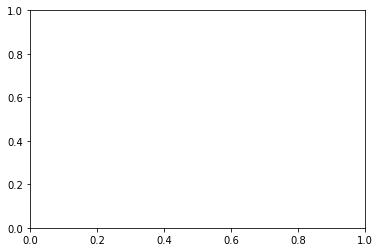

In [12]:

fig, ax = plt.subplots(facecolor = 'white')
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
# ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
fig.savefig(f'./graphs1/loss_lr_{lr}_long.png')
print(f'./graphs1/loss_lr_{lr}.png')

## AUC

NameError: name 'cnn_dr' is not defined

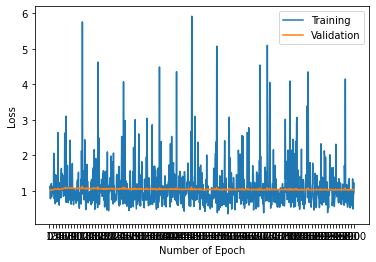

In [ ]:
fig, ax = plt.subplots(facecolor = 'white')
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}, cnn_dr:{cnn_dr}, cnn_dr:{fc_dr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()

In [ ]:
test_dataset = OneHotSeqsDataset(test_data, test_target, one_hot_dtype=torch.float)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, collate_fn=collate_padded_batch ,num_workers=8)

In [ ]:
torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

model.load_state_dict(torch.load('saved_weights/training_torch_simple_mask_copy_split_model_128f64n-spe30-rand5-100e'))

output = []
model.eval()
with torch.no_grad():

    for x, y in test_loader:
        x_batch = torch.squeeze(x, 0).to(device)
        y_batch = y.to(device)
        x_batch = x_batch.float()
        y_batch = y_batch.float()
        pred = model(x_batch.float())
        output.append(pred)
        
original_value_output = np.exp(output)

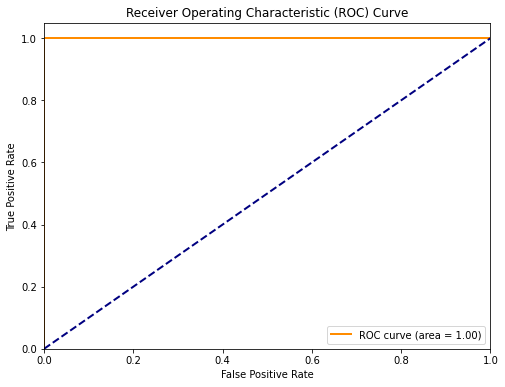

AUC Score: 1.0


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

def calculate_auc(labels, scores):
    """
    Calculate the Area Under the Receiver Operating Characteristic Curve (AUC)
    given true binary labels and prediction scores.
    
    :param labels: List of true binary labels (0 or 1).
    :param scores: List of prediction scores (probabilities or continuous output of the model).
    :return: AUC score.
    """
    auc_score = roc_auc_score(labels, scores)
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(labels, scores)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return auc_score

# Example usage
true_labels = [0, 1, 1, 0, 1]  # True binary labels
prediction_scores = [0.1, 0.4, 0.8, 0.3, 0.7]  # Prediction scores or probabilities

auc_score = calculate_auc(true_labels, prediction_scores)
print(f"AUC Score: {auc_score}")

# testing out hyper-parameters

143

In [11]:
import subprocess

def run_bash_command(command):
    """
    Runs a bash command and returns its output.
    
    :param command: The command to run as a string.
    :return: A tuple containing the command's stdout and stderr.
    """
    try:
        # Run command
        result = subprocess.run(command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        
        # Return stdout and stderr
        return result.stdout, result.stderr
    except subprocess.CalledProcessError as e:
        # Handle errors in the called executable
        return e.stdout, e.stderr
    except Exception as e:
        # Handle other errors related to subprocess.run()
        return None, str(e)

# Example usage
stdout, stderr = run_bash_command('nvidia-smi')
print('STDOUT:', stdout)
print('STDERR:', stderr)

# Example of a command that generates an error
stdout, stderr = run_bash_command('ls non_existent_file')
print('STDOUT:', stdout)
print('STDERR:', stderr)

STDOUT: Sun Mar 17 14:13:04 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:41:00.0 Off |                    0 |
| N/A   34C    P0    33W / 250W |    721MiB / 32510MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               


In [16]:

def find_range_vectorized(target_values, quest_values):
    # Convert lists to numpy arrays for efficient broadcasting
    target_values =  np.exp(np.array(target_values)) # Reshape for broadcasting
    quest_values =  np.exp(np.array(quest_values))

    # Perform broadcasting to compare each quest value against all target values
    # This creates a boolean matrix where rows correspond to target values and columns to quest values
    in_range_matrix = (target_values / 2 <= quest_values) & (quest_values <= target_values * 2)
    # in_range_matrix = np.abs(np.log2(target_values) - np.log2(quest_values))
    # in_range_matrix  = in_range_matrix  <= 1
    
    # print(mse)
    return in_range_matrix
# Example usage
# target_values = [[10, 20, 30, 40, 50], [10, 20, 30, 40, 50]]
# quest_values = [[25, 5, 60, 1, 1], [10, 20, 30, 40, 50]]

def save_to_file(file_path, appendix, epoch, lr, cnndr, fcdr, l2, train_loss, test_loss):
    train_loss = [float(arr) for arr in train_loss]
    test_loss = [float(arr) for arr in test_loss]
    with open(file_path, "a") as f:
        f.write(f">> {appendix}, Epoch: {epoch}, LR: {lr}, cnnDR: {cnndr},  fnDR: {fcdr}, l2decay: {l2}\n")
        f.write(f"--- Train Loss: {train_loss}\n")
        f.write(f"--- Test Loss: {test_loss}\n")
        
def hyper_params_test(appendix, lr, fc_dr=0,cnn_dr=0, l2=0, epoch=50):
    print('lr:', lr, '| fc_dr:',  fc_dr, '| cnn_dr:', cnn_dr, '| l2:', l2, '==='*10)
    torch.cuda.empty_cache()
    import gc; gc.collect()
    ic.disable()
    
    # stdout, stderr = run_bash_command('nvidia-smi')
    # print('STDOUT:', stdout)
    # print('STDERR:', stderr)
    # model = Model(
    # num_classes=13,
    # num_filters=128,
    # num_conv_layers=2,
    # num_dense_neurons=64, # batch_size = 64
    # num_dense_layers=2,
    # return_logits=True,
    # dense_dropout_rate=fc_dr,
    # conv_dropout_rate=cnn_dr
    # ).to(device)
    
    model = Model(
    num_classes=6,
    num_filters=64,
    num_conv_layers=2,
    num_dense_neurons=256, # batch_size = 64
    # num_dense_neurons=128, # batch_size = 64
    num_dense_layers=2,
    return_logits=True,
    conv_dropout_rate=cnn_dr,
    dense_dropout_rate=fc_dr
    ).to(device)

    # stdout, stderr = run_bash_command('nvidia-smi')
    # print('STDOUT:', stdout)
    # print('STDERR:', stderr)
    
    epoch = epoch
    batch_size = 128
    lr = lr

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch)
    test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch)
    # criterion = nn.MSELoss()
    criterion = masked_weighted_MSE
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)
    
    ic.disable()
    # ic.enable()
    train_epoch_loss = []
    test_epoch_loss = []

    for e in tqdm(range(1, epoch+1)):
        model.train()
        train_batch_loss = []
        test_batch_loss = []
        
        for x, y in train_loader:
            x_batch = torch.squeeze(x, 0).to(device)
            y_batch = y.to(device)
            x_batch = x_batch.float()
            y_batch = y_batch.float()
            pred = model(x_batch.float())
            loss_train = criterion(y_batch, pred)
            ic(loss_train)
            train_batch_loss.append(loss_train)
    
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            # print(f'Batch - GPU Memory Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB')
        train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
        with torch.no_grad():
            # print('test')
            for x, y in test_loader:
                x_batch = x.to(device)
                y_batch = y.to(device)
                pred = model(x_batch.float())
                loss_test = criterion(y_batch, pred)
                test_batch_loss.append(loss_test)
            test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())
    
     #! testing benchmark
    testing_dataset = Dataset(test_data, test_target, one_hot_dtype=torch.float, transform=True)
    testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)

    # drugs = ['AMI', 'BDQ', 'CFZ', 'DLM', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD', 'MXF', 'RIF', 'RFB']
    drugs = ['AMI_MIC','EMB_MIC', 'INH_MIC', 'KAN_MIC', 'RIF_MIC', 'RFB_MIC']

    model.eval()
    pred_list = []
    target_list = []
    mse_list = []
    with torch.no_grad():
        for x_test, y_test in testing_loader1:
            xtest1 = x_test.to(device).float()
            ytest1 = y_test.to(device).float()
            pred = model(xtest1)
            pred_list.append(pred.detach().cpu().numpy()) 
            target_list.append(y_test.detach().cpu().numpy())

    pred_list = np.array(pred_list).squeeze()
    target_list = np.array(target_list).squeeze()
    mse_list = (pred_list - target_list)**2
    mse_out = np.nanmean(mse_list, axis=0)

    result = find_range_vectorized(target_list, pred_list)

    # Append output to a file
    with open('trials3.txt', 'a') as f:
        mse_drug_output = f"====MIC-mse: {drugs} {np.mean(mse_out)}\n"
        f.write(mse_drug_output)        
        ea_accuracy_output = f"====EA-accuracy: {drugs} {np.nanmean(result, axis=0)}\n"
        f.write(ea_accuracy_output)
        print(mse_drug_output)
        print(ea_accuracy_output)
        # for x, y in zip(drugs, np.nanmean(result, axis=0).tolist()):
        #     print(x, y)        
            
            
    x = np.arange(1, epoch+1, 1)
    fig, ax = plt.subplots(facecolor = 'white')
    ax.plot(x, train_epoch_loss,label='Training')
    ax.plot(x, test_epoch_loss,label='Validation')
    ax.legend()
    ax.set_xlabel("Number of Epoch")
    ax.set_ylabel("Loss")
    ax.set_xticks(np.arange(0, epoch+1, 10))
    ax.set_title(f'Loss: Learning_rate:{lr}, cnn_dr:{cnn_dr}, fc_dr:{fc_dr}')
    # ax_2 = ax.twinx()
    # ax_2.plot(history["lr"], "k--", lw=1)
    # ax_2.set_yscale("log")
    # ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
    ax.grid(axis="x")
    fig.tight_layout()
    fig.show()
    fig.savefig(f'./graphs2/{appendix}_loss_lr_{lr}_cnn_dr_{cnn_dr}_fc_dr_{fc_dr}_l2{l2}_weighted_balanced.png')
    save_to_file('trials3.txt', appendix ,epoch, lr, cnn_dr, fc_dr, l2, train_epoch_loss, test_epoch_loss)
    print(f'./graphs2/{appendix}_loss_lr_{lr}_cnn_dr_{cnn_dr}_fc_dr_{fc_dr}_l2{l2}_weighted_balanced.png')
    
    torch.save({
    'optimizer': optimizer.state_dict(),
    'model': model.state_dict(),
}, '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/{appendix}-{epoch}-{lr}-{cnndr}-{fcdr}-{l2}_weighted_balanced.pth')

lr: 0.0001 | fc_dr: 0.1 | cnn_dr: 0 | l2: 0 ==============================


100%|██████████| 300/300 [2:13:23<00:00, 26.68s/it]  


====MIC-mse: ['AMI_MIC', 'EMB_MIC', 'INH_MIC', 'KAN_MIC', 'RIF_MIC', 'RFB_MIC'] 1.189979910850525

====EA-accuracy: ['AMI_MIC', 'EMB_MIC', 'INH_MIC', 'KAN_MIC', 'RIF_MIC', 'RFB_MIC'] [0.58473154 0.75251678 0.55620805 0.59731544 0.56711409 0.77768456]

./graphs2/aa-64-2-256-2-128-log-reg-weighted_balanced_loss_lr_0.0001_cnn_dr_0_fc_dr_0.1_l20_weighted_balanced.png


/tmp/ipykernel_31848/1111735769.py:162: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


lr: 0.0001 | fc_dr: 0.2 | cnn_dr: 0 | l2: 0 ==============================


100%|██████████| 300/300 [2:13:22<00:00, 26.68s/it]  


====MIC-mse: ['AMI_MIC', 'EMB_MIC', 'INH_MIC', 'KAN_MIC', 'RIF_MIC', 'RFB_MIC'] 1.1839816570281982

====EA-accuracy: ['AMI_MIC', 'EMB_MIC', 'INH_MIC', 'KAN_MIC', 'RIF_MIC', 'RFB_MIC'] [0.57130872 0.7533557  0.57802013 0.58808725 0.59479866 0.8045302 ]

./graphs2/aa-64-2-256-2-128-log-reg-weighted_balanced_loss_lr_0.0001_cnn_dr_0_fc_dr_0.2_l20_weighted_balanced.png
lr: 0.0001 | fc_dr: 0.3 | cnn_dr: 0 | l2: 0 ==============================


/tmp/ipykernel_31848/1111735769.py:162: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 300/300 [2:13:20<00:00, 26.67s/it]  


====MIC-mse: ['AMI_MIC', 'EMB_MIC', 'INH_MIC', 'KAN_MIC', 'RIF_MIC', 'RFB_MIC'] 1.2195874452590942

====EA-accuracy: ['AMI_MIC', 'EMB_MIC', 'INH_MIC', 'KAN_MIC', 'RIF_MIC', 'RFB_MIC'] [0.57969799 0.74916107 0.58053691 0.57466443 0.59144295 0.80536913]

./graphs2/aa-64-2-256-2-128-log-reg-weighted_balanced_loss_lr_0.0001_cnn_dr_0_fc_dr_0.3_l20_weighted_balanced.png
lr: 0.0001 | fc_dr: 0.4 | cnn_dr: 0 | l2: 0 ==============================


/tmp/ipykernel_31848/1111735769.py:162: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 300/300 [2:13:19<00:00, 26.66s/it]  


====MIC-mse: ['AMI_MIC', 'EMB_MIC', 'INH_MIC', 'KAN_MIC', 'RIF_MIC', 'RFB_MIC'] 1.2466766834259033

====EA-accuracy: ['AMI_MIC', 'EMB_MIC', 'INH_MIC', 'KAN_MIC', 'RIF_MIC', 'RFB_MIC'] [0.58221477 0.74916107 0.58137584 0.56795302 0.58557047 0.81711409]

./graphs2/aa-64-2-256-2-128-log-reg-weighted_balanced_loss_lr_0.0001_cnn_dr_0_fc_dr_0.4_l20_weighted_balanced.png
lr: 0.0001 | fc_dr: 0.5 | cnn_dr: 0 | l2: 0 ==============================


/tmp/ipykernel_31848/1111735769.py:162: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 300/300 [2:13:20<00:00, 26.67s/it]  


====MIC-mse: ['AMI_MIC', 'EMB_MIC', 'INH_MIC', 'KAN_MIC', 'RIF_MIC', 'RFB_MIC'] 1.2652493715286255

====EA-accuracy: ['AMI_MIC', 'EMB_MIC', 'INH_MIC', 'KAN_MIC', 'RIF_MIC', 'RFB_MIC'] [0.58305369 0.74496644 0.5864094  0.55704698 0.59647651 0.81627517]

./graphs2/aa-64-2-256-2-128-log-reg-weighted_balanced_loss_lr_0.0001_cnn_dr_0_fc_dr_0.5_l20_weighted_balanced.png
lr: 1e-05 | fc_dr: 0 | cnn_dr: 0 | l2: 0 ==============================


/tmp/ipykernel_31848/1111735769.py:162: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 300/300 [2:13:21<00:00, 26.67s/it]  


====MIC-mse: ['AMI_MIC', 'EMB_MIC', 'INH_MIC', 'KAN_MIC', 'RIF_MIC', 'RFB_MIC'] 1.341718316078186

====EA-accuracy: ['AMI_MIC', 'EMB_MIC', 'INH_MIC', 'KAN_MIC', 'RIF_MIC', 'RFB_MIC'] [0.54530201 0.71392617 0.53439597 0.55201342 0.5033557  0.71979866]

./graphs2/aa-64-2-256-2-128-log-reg-weighted_balanced_loss_lr_1e-05_cnn_dr_0_fc_dr_0_l20_weighted_balanced.png
lr: 1e-05 | fc_dr: 0.1 | cnn_dr: 0 | l2: 0 ==============================


/tmp/ipykernel_31848/1111735769.py:162: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 300/300 [2:13:23<00:00, 26.68s/it]  


====MIC-mse: ['AMI_MIC', 'EMB_MIC', 'INH_MIC', 'KAN_MIC', 'RIF_MIC', 'RFB_MIC'] 1.2327800989151

====EA-accuracy: ['AMI_MIC', 'EMB_MIC', 'INH_MIC', 'KAN_MIC', 'RIF_MIC', 'RFB_MIC'] [0.53104027 0.72651007 0.57298658 0.58137584 0.51258389 0.7533557 ]

./graphs2/aa-64-2-256-2-128-log-reg-weighted_balanced_loss_lr_1e-05_cnn_dr_0_fc_dr_0.1_l20_weighted_balanced.png
lr: 1e-05 | fc_dr: 0.2 | cnn_dr: 0 | l2: 0 ==============================


/tmp/ipykernel_31848/1111735769.py:162: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 300/300 [2:13:17<00:00, 26.66s/it]  


====MIC-mse: ['AMI_MIC', 'EMB_MIC', 'INH_MIC', 'KAN_MIC', 'RIF_MIC', 'RFB_MIC'] 1.2674537897109985

====EA-accuracy: ['AMI_MIC', 'EMB_MIC', 'INH_MIC', 'KAN_MIC', 'RIF_MIC', 'RFB_MIC'] [0.52097315 0.73573826 0.56879195 0.56124161 0.52013423 0.79026846]

./graphs2/aa-64-2-256-2-128-log-reg-weighted_balanced_loss_lr_1e-05_cnn_dr_0_fc_dr_0.2_l20_weighted_balanced.png
lr: 1e-05 | fc_dr: 0.3 | cnn_dr: 0 | l2: 0 ==============================


/tmp/ipykernel_31848/1111735769.py:162: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 300/300 [2:13:17<00:00, 26.66s/it]  


====MIC-mse: ['AMI_MIC', 'EMB_MIC', 'INH_MIC', 'KAN_MIC', 'RIF_MIC', 'RFB_MIC'] 1.414421558380127

====EA-accuracy: ['AMI_MIC', 'EMB_MIC', 'INH_MIC', 'KAN_MIC', 'RIF_MIC', 'RFB_MIC'] [0.52013423 0.63758389 0.52181208 0.54530201 0.47063758 0.76677852]

./graphs2/aa-64-2-256-2-128-log-reg-weighted_balanced_loss_lr_1e-05_cnn_dr_0_fc_dr_0.3_l20_weighted_balanced.png
lr: 1e-05 | fc_dr: 0.4 | cnn_dr: 0 | l2: 0 ==============================


/tmp/ipykernel_31848/1111735769.py:162: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 300/300 [3:45:30<00:00, 45.10s/it]  


====MIC-mse: ['AMI_MIC', 'EMB_MIC', 'INH_MIC', 'KAN_MIC', 'RIF_MIC', 'RFB_MIC'] 1.4719117879867554

====EA-accuracy: ['AMI_MIC', 'EMB_MIC', 'INH_MIC', 'KAN_MIC', 'RIF_MIC', 'RFB_MIC'] [0.5033557  0.57466443 0.48825503 0.56208054 0.46392617 0.80620805]

./graphs2/aa-64-2-256-2-128-log-reg-weighted_balanced_loss_lr_1e-05_cnn_dr_0_fc_dr_0.4_l20_weighted_balanced.png
lr: 1e-05 | fc_dr: 0.5 | cnn_dr: 0 | l2: 0 ==============================


/tmp/ipykernel_31848/1111735769.py:162: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
  0%|          | 0/300 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 846.00 MiB (GPU 0; 31.75 GiB total capacity; 15.42 MiB already allocated; 788.50 MiB free; 16.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

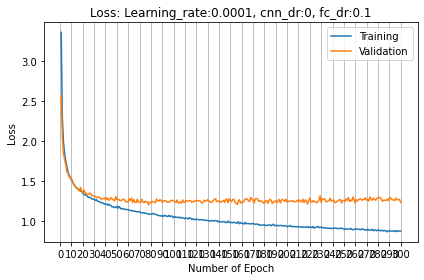

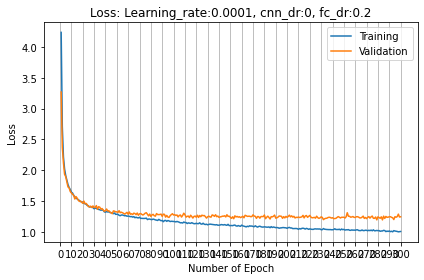

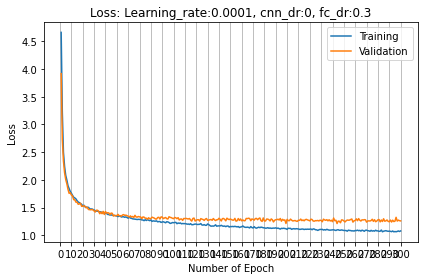

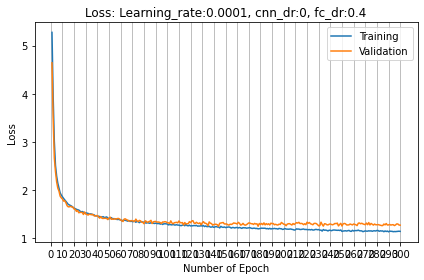

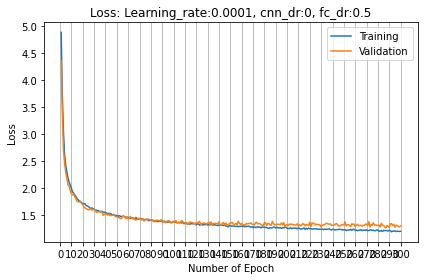

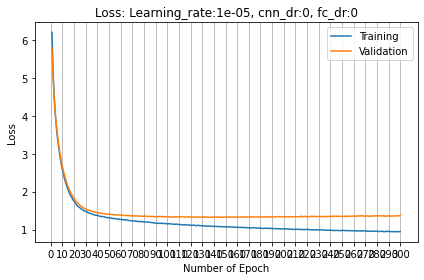

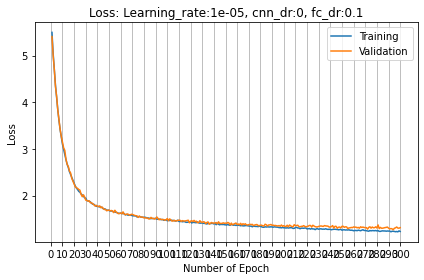

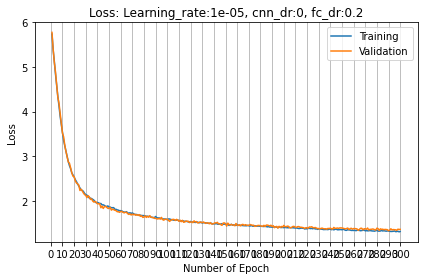

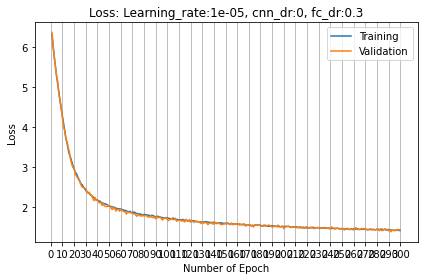

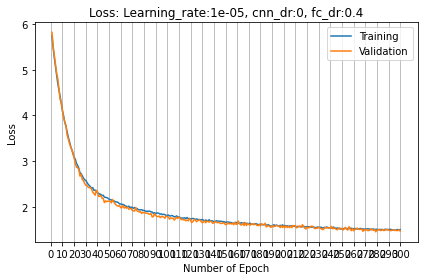

In [17]:
torch.cuda.empty_cache()
import gc; gc.collect()

# epoch = 250
# for lr in [1e-4]:
#     for fc_dr in [0.2]:
#         for decay in [1e-9]:
#             for cnn_dr in [0.2, 0.3, 0.4, 0.5]:
#                 hyper_params_test('64-2-256-2-128-log-reg-weighted_balanced', lr, cnn_dr = 0, fc_dr=fc_dr, l2=decay, epoch=epoch)

epoch = 300
for lr in [1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]:
    for fc_dr in [0,0.1, 0.2, 0.3, 0.4, 0.5]:
        for decay in [0]:
            if lr == 1e-4 and fc_dr == 0:
                continue
            else:
                hyper_params_test('aa-64-2-256-2-128-log-reg-weighted_balanced', lr, cnn_dr = 0, fc_dr=fc_dr, l2=decay, epoch=epoch)
# epoch = 44
# for lr in [1e-4]:
#     for fc_dr in [0.4]:
#         for cnn_dr in [0.4]:
#             for decay in [1e-8]:
#                 hyper_params_test('final_model', lr, fc_dr=fc_dr, cnn_dr=cnn_dr, l2=decay, epoch=epoch)

# epoch = 50
# for lr in [1e-4]:
#     for fc_dr in [0.4]:
#         for cnn_dr in [0, 0.2, 0.3, 0.4, 0.5]:
#             for decay in [1e-8]:
#                 hyper_params_test('64-2-256-2-128-log-reg', lr, fc_dr=fc_dr, cnn_dr=cnn_dr, l2=decay, epoch=epoch)

lr: 0.004 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:21<00:00, 55.09s/it]


lr: 0.005 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:24<00:00, 55.23s/it]


lr: 0.007 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:13<00:00, 54.66s/it]


lr: 0.008 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:10<00:00, 54.54s/it]


lr: 0.0085 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:20<00:00, 55.00s/it]


lr: 0.0095 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:13<00:00, 54.69s/it]


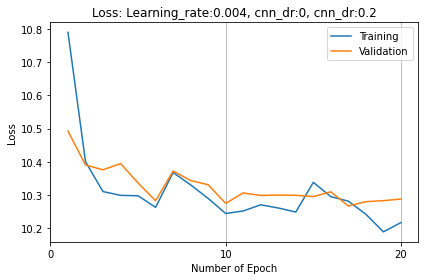

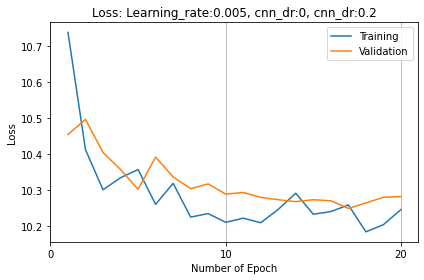

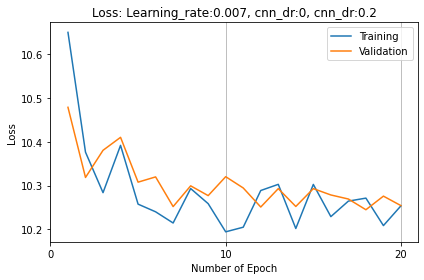

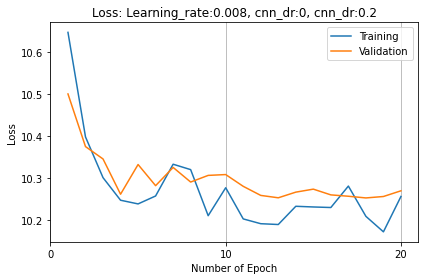

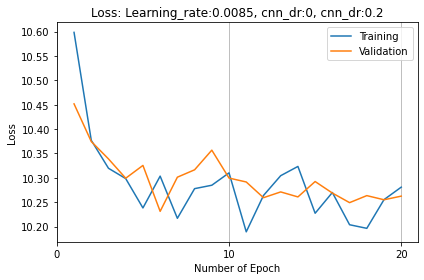

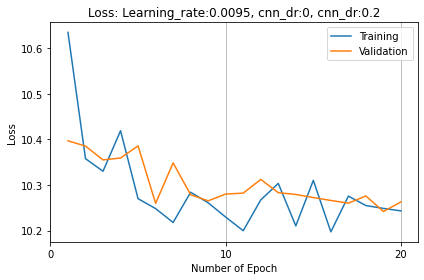

In [ ]:
# for x in np.arange(0.0000,0.0101,0.0005):
for x in [0.004,0.005, 0.007,0.008,0.0085, 0.0095]:
    if x == 0:
        continue
    else:
        hyper_params_test(x, epoch=20)

In [ ]:
# for x in np.arange(0.0000,0.0101,0.0005):
for x in [0.004,0.005, 0.007,0.008,0.0085, 0.0095]:
    if x == 0:
        continue
    else:
        hyper_params_test(x, epoch=20)

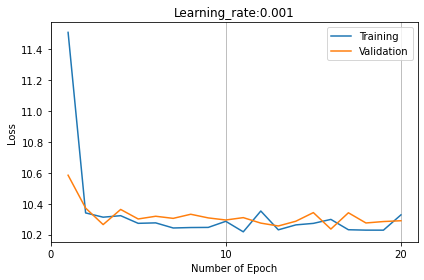

In [ ]:
#%%
fig, ax = plt.subplots(facecolor = 'white')
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
#%%
# a = torch.zeros(1, 2, 3, 4, 5, 6)
# b = a.view(a.shape[:2], -1, a.shape[5:])
# %%
# from torchviz import make_dot
# x = torch.randn(2, 4, 56).to(device)
# m = model_torch_simple.raw_seq_model().to(device)
# y = m(x)
# make_dot(y, params=dict(list(m.named_parameters()))).render("cnn_torchviz", format="png")

# Testing

In [24]:
testing_dataset = OneHotSeqsDataset(test_data, test_target, one_hot_dtype=torch.float, transform=True)
testing_loader = DataLoader(dataset=testing_dataset, batch_size=128, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)

## batch running

In [25]:

save_path = '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted.pth'

# Load the saved file
checkpoint = torch.load(save_path)
ic.disable()

# Initialize the model and optimizer
model = Model(
num_classes=13,
num_filters=64,
num_conv_layers=2,
num_dense_neurons=256, # batch_size = 64
# num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=True,
conv_dropout_rate=0,
dense_dropout_rate=0.2
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=1e-9)

# optimizer = optimizer_class(model.parameters(), ...)  # Add the necessary arguments as per your optimizer's initialization method

# Load the model and optimizer states
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

# Make sure to call .eval() or .train() on your model depending on what you're planning to do next
model.eval()  # For inference
# or
# model.train()  # For further training


pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader:
        x_batch = torch.squeeze(x_test, 0).to(device)
        x_batch = x_batch.float()
        y_batch = y_test.float().to(device)
        # print(x_batch.size())
        # y_batch = torch.Tensor.float(y).to(device)
        # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
        pred = model(x_batch.float())
        pred_list.append(pred)
        target_list.append(y_batch)
        # pred = pred.unsqueeze(0)
        loss_test = criterion(y_batch, pred)
        mse_list.append(loss_test)
        # test_batch_loss.append(loss_test)
        # test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_final_weighted'

### Overall test

In [48]:
testing_dataset = OneHotSeqsDataset(test_data, test_target, one_hot_dtype=torch.float, transform=True)
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)

In [15]:
testing_dataset = Dataset(test_data, test_target, one_hot_dtype=torch.float, transform=True)
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)


save_path = '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted.pth'

# Load the saved file
checkpoint = torch.load(save_path)
ic.disable()

# Initialize the model and optimizer
model = Model(
num_classes=13,
num_filters=64,
num_conv_layers=2,
num_dense_neurons=256, # batch_size = 64
# num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=True,
conv_dropout_rate=0,
dense_dropout_rate=0.2
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=1e-9)

# optimizer = optimizer_class(model.parameters(), ...)  # Add the necessary arguments as per your optimizer's initialization method

# Load the model and optimizer states
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

# Make sure to call .eval() or .train() on your model depending on what you're planning to do next
model.eval()  # For inference

ic.disable()
model.eval()
pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader1:
        xtest1 = x_test.to(device).float()
        ytest1 = y_test.to(device).float()
        pred = model(xtest1)
        pred_list.append(pred.detach().cpu().numpy()) 
        target_list.append(y_test.detach().cpu().numpy())

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted.pth'

### in memory model

In [16]:
testing_dataset = Dataset(test_data, test_target, one_hot_dtype=torch.float, transform=True)
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)

ic.disable()
model.eval()
pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader1:
        xtest1 = x_test.to(device).float()
        ytest1 = y_test.to(device).float()
        pred = model(xtest1)
        pred_list.append(pred.detach().cpu().numpy()) 
        target_list.append(y_test.detach().cpu().numpy())

In [25]:
# First, let's write a function that accepts a list of values and a list of thresholds.
# The function will compare each value with its corresponding threshold and return a list of binary values.

def threshold_binary_list(values, thresholds):
    # This function will compare values with thresholds and return a binary list
    values = np.exp(values)
    binary_list = [1 if value >= threshold else 0 for value, threshold in zip(values, thresholds)]
    return binary_list

# List of thresholds as per the image provided by the user
thresholds = [2, 0.5, 0.5, 0.25, 8, 8, 0.8, 8, 8, 2, 2, 1, 0.25]

# Example list of values to be checked against the thresholds
values = [3, 0.7, 0.4, 0.3, 10, 5, 1, 9, 7, 2, 3, 0.5, 0.3]  # This is a placeholder

# Get the binary list using the function defined above
binary_list = threshold_binary_list(pred_list[0][0], thresholds)
binary_list


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

### Getting accuracy and stuff

In [21]:
column_accuracies

[0.9521812080536913,
 0.8095637583892618,
 0.8917785234899329,
 0.9328859060402684,
 0.9052013422818792,
 0.9135906040268457]

In [22]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


# First, let's write a function that accepts a list of values and a list of thresholds.
# The function will compare each value with its corresponding threshold and return a list of binary values.
# thresholds = [2, 0.5, 0.5, 0.25, 8, 8, 0.8, 8, 8, 2, 2, 1, 0.25]
thresholds = [2, 8, 0.8, 8, 1, 0.25]

def threshold_binary_list(values, thresholds):
    # This function will compare values with thresholds and return a binary list
    values = np.exp(values)
    binary_list = [1 if value >= threshold else 0 for value, threshold in zip(values, thresholds)]
    return binary_list

pred_list_rs = []
target_list_rs = []

for x in tqdm(pred_list):
    pred_list_rs.append(threshold_binary_list(x[0], thresholds))
for x in tqdm(target_list):
    target_list_rs.append(threshold_binary_list(x[0], thresholds))

np.random.seed(0)  # Seed for reproducibility
y_true = np.array(target_list_rs)
y_pred = np.array(pred_list_rs)

# Initialize lists to store metrics for each column
column_accuracies = []
column_f1_scores = []
column_conf_matrices = []

# Calculate accuracy, F1 score, and confusion matrix for each column
for i in range(y_true.shape[1]):
    column_accuracies.append(accuracy_score(y_true[:, i], y_pred[:, i]))
    column_f1_scores.append(f1_score(y_true[:, i], y_pred[:, i], zero_division=0))
    column_conf_matrices.append(confusion_matrix(y_true[:, i], y_pred[:, i]))

# Calculate overall metrics for the entire matrix
overall_accuracy = accuracy_score(y_true.ravel(), y_pred.ravel())
overall_f1_score = f1_score(y_true.ravel(), y_pred.ravel(), zero_division=0)
overall_conf_matrix = confusion_matrix(y_true.ravel(), y_pred.ravel())

# Output the results
column_metrics = list(zip(column_accuracies, column_f1_scores, column_conf_matrices))
overall_metrics = (overall_accuracy, overall_f1_score, overall_conf_matrix)

column_metrics, overall_metrics

result_df = pd.DataFrame(columns=['Drugs','accuracy', 'f1_score', 'True Negative (TN)', 'False Positive (FP)','False Negative (FN)', 'True Positive (TP)'])
# result_df['Drugs'] = ['AMI', 'BDQ', 'CFZ', 'DLM', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD', 'MXF', 'RIF', 'RFB']
result_df['Drugs'] = ['AMI',  'EMB', 'INH', 'KAN', 'RIF', 'RFB']
result_df['accuracy'] = column_accuracies
result_df['f1_score'] = column_f1_scores
result_df['True Negative (TN)'] = np.array(column_conf_matrices)[:,0,0]
result_df['False Positive (FP)'] = np.array(column_conf_matrices)[:,0,1]
result_df['False Negative (FN)'] = np.array(column_conf_matrices)[:,1,0]
result_df['True Positive (TP)'] = np.array(column_conf_matrices)[:,1,1]
# print(np.array(column_conf_matrices)[:,0,0])
# print(np.array(column_conf_matrices)[:,0,1])
# print(np.array(column_conf_matrices)[:,1,0])
# print(np.array(column_conf_matrices)[:,1,1])
result_df['Sensitivity'] = result_df['True Positive (TP)'] / (result_df['True Positive (TP)'] + result_df['False Negative (FN)'])
result_df['Specificity'] = result_df['True Negative (TN)'] / (result_df['True Negative (TN)'] + result_df['False Positive (FP)'])

pred_list = np.array(pred_list).squeeze()
target_list = np.array(target_list).squeeze()
mse_list = (pred_list - target_list)**2
mse_out = np.nanmean(mse_list, axis=0)
result_df['MSE'] = mse_out

print(result_df)

100%|██████████| 1192/1192 [00:00<00:00, 49330.15it/s]

  Drugs  accuracy  f1_score  True Negative (TN)  False Positive (FP)   
0   AMI  0.952181  0.564885                1098                    6  \
1   EMB  0.809564  0.095618                 953                    2   
2   INH  0.891779  0.861736                 661                   53   
3   KAN  0.932886  0.459459                1078                    4   
4   RIF  0.905201  0.871445                 696                   38   
5   RFB  0.913591  0.878107                 718                   33   

   False Negative (FN)  True Positive (TP)  Sensitivity  Specificity       MSE  
0                   51                  37     0.420455     0.994565  1.228719  
1                  225                  12     0.050633     0.997906  0.611419  
2                   76                 402     0.841004     0.925770  1.668461  
3                   76                  34     0.309091     0.996303  0.883237  
4                   75                 383     0.836245     0.948229  1.908700  
5        

In [23]:
result_df

,Drugs,accuracy,f1_score,True Negative (TN),False Positive (FP),False Negative (FN),True Positive (TP),Sensitivity,Specificity,MSE
0,AMI,0.952181,0.564885,1098,6,51,37,0.420455,0.994565,1.228719
1,EMB,0.809564,0.095618,953,2,225,12,0.050633,0.997906,0.611419
2,INH,0.891779,0.861736,661,53,76,402,0.841004,0.925770,1.668461
3,KAN,0.932886,0.459459,1078,4,76,34,0.309091,0.996303,0.883237
4,RIF,0.905201,0.871445,696,38,75,383,0.836245,0.948229,1.908700
5,RFB,0.913591,0.878107,718,33,70,371,0.841270,0.956059,1.160375


In [55]:
result_df['MSE'] = mse_out

In [56]:
result_df

,Drugs,accuracy,f1_score,True Negative (TN),False Positive (FP),False Negative (FN),True Positive (TP),Sensitivity,Specificity,MSE
0,AMI,0.980100,0.862069,1107,11,13,75,0.852273,0.990161,0.727826
1,BDQ,0.995025,0.000000,1200,0,6,0,0.000000,1.000000,0.773941
2,CFZ,0.954395,0.000000,1151,0,55,0,0.000000,1.000000,0.966274
3,DLM,0.985904,0.000000,1189,0,17,0,0.000000,1.000000,0.997328
4,EMB,0.930348,0.000000,1122,0,84,0,0.000000,1.000000,0.573841
5,ETH,0.912106,0.018519,1099,0,106,1,0.009346,1.000000,0.718624
6,INH,0.929519,0.912281,679,31,54,442,0.891129,0.956338,1.409090
7,KAN,0.985075,0.891566,1114,11,7,74,0.913580,0.990222,0.625009
8,LEV,0.975954,0.000000,1177,0,29,0,0.000000,1.000000,0.685530
9,LZD,0.985904,0.000000,1189,0,17,0,0.000000,1.000000,0.422045


In [39]:
np.mean([x.detach().cpu().numpy() for x in mse_list])

0.90581405

In [142]:
# testing_dataset = OneHotSeqsDataset(test_data, test_target, one_hot_dtype=torch.float, transform=True)
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
ic.disable()
model.eval()
pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader1:
        xtest1 = x_test.to(device).float()
        ytest1 = y_test.to(device).float()
        pred = model(xtest1)
        pred_list.append(pred.detach().cpu().numpy()) 
        target_list.append(y_test.detach().cpu().numpy())

## Mic calc

In [54]:
pred_list = np.array(pred_list).squeeze()
target_list = np.array(target_list).squeeze()
mse_list = (pred_list - target_list)**2
mse_out = np.nanmean(mse_list, axis=0)
print(mse_out)
print(np.mean(mse_out))

[0.72782607 0.77394133 0.96627392 0.99732814 0.57384106 0.71862384
 1.40909006 0.62500867 0.68552988 0.42204546 0.90296875 1.86967643
 1.116575  ]
0.9068252765540421


In [147]:
pred_list = np.array(pred_list).squeeze()
target_list = np.array(target_list).squeeze()
mse_list = (np.exp(pred_list) - np.exp(target_list))**2
mse_out = np.nanmean(mse_list, axis=0)
print(mse_out)
print(np.mean(mse_out))

[1.99657691e+01 2.19492095e-02 1.20861531e-01 1.84303685e-02
 2.18870026e+01 1.48684251e+01 1.62012543e+01 2.61311525e+01
 6.15298126e+00 2.21063227e-01 1.96245250e+00 1.24928044e+01
 9.46748127e-01]
9.30699186242598


## Ea calc

In [129]:
def find_range_vectorized(target_values, quest_values):
    # Convert lists to numpy arrays for efficient broadcasting
    target_values =  np.exp(np.array(target_values)) # Reshape for broadcasting
    quest_values =  np.exp(np.array(quest_values))

    # Perform broadcasting to compare each quest value against all target values
    # This creates a boolean matrix where rows correspond to target values and columns to quest values
    in_range_matrix = (target_values / 2 <= quest_values) & (quest_values <= target_values * 2)
    # in_range_matrix = np.abs(np.log2(target_values) - np.log2(quest_values))
    # in_range_matrix  = in_range_matrix  <= 1
    
    # print(mse)
    return in_range_matrix
# Example usage
# target_values = [[10, 20, 30, 40, 50], [10, 20, 30, 40, 50]]
# quest_values = [[25, 5, 60, 1, 1], [10, 20, 30, 40, 50]]
result = find_range_vectorized(target_list, pred_list)

In [148]:
np.exp(pred_list[0])

array([0.21734211, 0.04858502, 0.07807854, 0.01177044, 1.1826788 ,
       1.069281  , 0.02535057, 1.8139412 , 0.41462198, 0.45923612,
       0.28088352, 0.1602019 , 0.06000657], dtype=float32)

In [135]:
target_values_ =  np.exp(np.array(target_list)) # Reshape for broadcasting
quest_values_ =  np.exp(np.array(pred_list))


In [111]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score


for i in range(result.shape[0]):
    f1 = f1_score(y_true, result[i, :])
    accuracy = accuracy_score(y_true, result[i, :])
    print(f"Model {i+1} - F1 Score: {f1}, Accuracy: {accuracy}")


NameError: name 'y_true' is not defined

In [ ]:
def EA_calc(target_matrix: np.array):
    drugs = ['AMI', 'BDQ', 'CFZ', 'DLM', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD', 'MXF', 'RIF', 'RFB']
    for x, drug in zip(range(target_matrix.shape[1]), drugs):
        ea_count = len([item for item in target_matrix[:,x] if item == True])
        ea_rate = (ea_count / len(target_matrix[:,x])) * 100
        print(drug, ea_rate)
        
def MSE_calc(target_matrix: np.array):
    drugs = ['AMI', 'BDQ', 'CFZ', 'DLM', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD', 'MXF', 'RIF', 'RFB']
    for x, drug in zip(range(target_matrix.shape[1]), drugs):
        mse = np.mean(target_matrix[:,x])
        print(drug, mse)
        

# Explanable AI

### Sensitivity analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Assume `input_data` is your input tensor, and `feature_index` is the index of the feature to perturb
perturbation_range = np.linspace(0, 1, num=20)  # Example range of perturbation
original_value = input_data[0, feature_index].item()  # Store original value

output_changes = np.zeros((len(perturbation_range), 13))  # Store changes in outputs

for i, perturb in enumerate(perturbation_range):
    input_data[0, feature_index] = original_value + perturb  # Perturb feature value
    with torch.no_grad():
        outputs = model(input_data).numpy()  # Get model output
    output_changes[i] = outputs  # Record the change

# Reset the perturbed feature to its original value
input_data[0, feature_index] = original_value

# Example analysis for one output
plt.figure(figsize=(10, 6))
for output_index in range(13):
    plt.plot(perturbation_range, output_changes[:, output_index], label=f'Output {output_index+1}')

plt.xlabel('Perturbation')
plt.ylabel('Output Change')
plt.title('Sensitivity Analysis of Feature X on All Outputs')
plt.legend()
plt.show()


### SHAP

In [ ]:
import torch
import numpy as np

def model_wrapper(x):
    with torch.no_grad():
        # Convert the input numpy array to a PyTorch tensor
        tensor_x = torch.tensor(x, dtype=torch.float32)
        # Make a prediction with your model
        model_output = model(tensor_x)
        # Convert the prediction back to a numpy array
        return model_output.numpy()


In [ ]:
import shap

# Sample data for initialization (e.g., a batch from your training data)
X_sample = np.array([...])  # Replace with your actual numpy array

# Initialize the explainer
explainer = shap.KernelExplainer(model_wrapper, X_sample)

# Choose the instance you want to explain
X_instance = np.array([...])  # Replace with the instance in numpy array format

# Calculate SHAP values
shap_values = explainer.shap_values(X_instance)

# Plotting the SHAP values
shap.initjs()  # Initializes JavaScript visualization in Jupyter Notebooks
shap.force_plot(explainer.expected_value, shap_values, X_instance)


### Counterfactual

In [ ]:
### SHAP